In [1]:
# sys
import os
import csv
import sys
# math
import numpy as np
import pandas as pd
# data cleaning
sys.path.append('/home/flink/workspace/yimin/Flink-SQL-Metrics-Tracer/src/cleaners')
from seq_cleaner import *
# learning
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,Input,Concatenate,Flatten
# visual
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Pre-processing

In [21]:
# read files and combine
f_paths = ['/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test2.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test3.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test4.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test5.csv',
          ]
df_raws = []
for f_path in f_paths:
    df_raws.append(pd.read_csv(f_path))
df_raw = pd.concat(df_raws, axis=0, ignore_index=True)
df_raw.shape

(6060, 2)

In [22]:
# define wanted dict
wanted_dict = {}
wanted_dict['run_confs'] = ['qid']
wanted_dict['vertex_level_metrics'] = ['parallelism',]
wanted_dict['vertex_id'] = 'idx'
wanted_dict['sub_level_metrics'] = [
                                    'busyTimeMsPerSecond', 
#                                     'Shuffle.Netty.Input.Buffers.inputQueueLength',
#                                     'Shuffle.Netty.Input.Buffers.inputQueueSize', 'Shuffle.Netty.Input.Buffers.inPoolUsage',
#                                     'Shuffle.Netty.Output.Buffers.outputQueueSize',
                                    'numBytesInPerSecond', 'numRecordsInPerSecond',]

In [4]:
# do data cleaning
scleaner = sequential_cleaner(wanted_dict)
df_raw[:].apply(scleaner.clean_row, axis=1)
len(scleaner.dataset), scleaner.dataset[:1]

(108240, [[4, 0, 2, 0, 'NaN', '0.0', '0.0']])

In [5]:
# make df and replace nan
df = pd.DataFrame(scleaner.dataset, columns=scleaner.get_head())
df = df.replace('NaN', np.nan)
(df.shape[0], df.shape[1], df.keys())

(108240,
 7,
 Index(['qid', 'vertex_idx', 'parallelism', 'sub_idx', 'busyTimeMsPerSecond',
        'numBytesInPerSecond', 'numRecordsInPerSecond'],
       dtype='object'))

# Part 1: redo vertex-level prediction on busy time

## Part 1.1: subtask-level

In [6]:
# complete some informations
in_stream_infos = {"in": {"0": {"0": 0}, "1": {"0": 0}, "2": {"0": 0}, "3": {"0": 0, "1": 1}, "4": {"0": 0, "1": 1, "2": 1, "3": 1}, "5": {"0": 0, "1": 1, "2": 1, "3": 2}, "7": {"0": 0, "1": 1, "2": 2}, "8": {"0": 0, "1": 1, "2": 1, "3": 2}, "9": {"0": 0, "1": 1, "2": 1}, "10": {"0": 0, "1": 1}, "11": {"0": 0, "1": 1}, "12": {"0": 0, "1": 1}, "13": {"0": 0}, "14": {"0": 0}, "15": {"0": 0, "1": 1}, "16": {"0": 0, "1": 1}, "17": {"0": 0, "1": 1}, "18": {"0": 0, "1": 1}, "19": {"0": 0, "1": 1}, "20": {"0": 0, "1": 1}, "21": {"0": 0}, "22": {"0": 0}}, "out": {"0": {"0": 0}, "1": {"0": 0}, "2": {"0": 0}, "3": {"0": 1, "1": 0}, "4": {"0": 1, "1": 1, "2": 1, "3": 0}, "5": {"0": 1, "1": 2, "2": 1, "3": 0}, "7": {"0": 2, "1": 1, "2": 0}, "8": {"0": 2, "1": 1, "2": 1, "3": 0}, "9": {"0": 1, "1": 1, "2": 0}, "10": {"0": 1, "1": 0}, "11": {"0": 1, "1": 0}, "12": {"0": 1, "1": 0}, "13": {"0": 0}, "14": {"0": 0}, "15": {"0": 1, "1": 0}, "16": {"0": 1, "1": 0}, "17": {"0": 1, "1": 0}, "18": {"0": 1, "1": 0}, "19": {"0": 1, "1": 0}, "20": {"0": 1, "1": 0}, "21": {"0": 0}, "22": {"0": 0}}}

# make complete dataset with input stream infos
def complete_stream_num_infos(qid, vid, io='in'):
#     print(qid, vid)
    qid = int(qid)
    vid = int(vid)
    if io == 'in':
        return in_stream_infos['in'][str(qid)][str(vid)]
    elif io == 'out':
        return in_stream_infos['out'][str(qid)][str(vid)]

def complete_row_in(row):
    return complete_stream_num_infos(row['query_idx'], row['vertex_idx'])

def complete_row_out(row):
    return complete_stream_num_infos(row['query_idx'], row['vertex_idx'], 'out')

In [90]:
# col name & dtype transform

df_naive = df
df_naive = df_naive[df_naive['busyTimeMsPerSecond'].notnull()]
df_naive.rename(columns = {'qid':'query_idx',}, inplace = True)

df_naive = df_naive.astype({"query_idx": int, 'vertex_idx': int, 'parallelism':int, 'sub_idx':int,
                           'busyTimeMsPerSecond': float, 
#                            'Shuffle.Netty.Input.Buffers.inputQueueLength': float,
#                            'Shuffle.Netty.Input.Buffers.inputQueueSize': float,
#                            'Shuffle.Netty.Input.Buffers.inPoolUsage': float,
#                             'Shuffle.Netty.Output.Buffers.outputQueueSize': float,
                           'numBytesInPerSecond': float, 'numRecordsInPerSecond': float,})

# complete information
df_naive['in_stream_num'] = df_naive.apply(complete_row_in, axis=1)
df_naive['out_stream_num'] = df_naive.apply(complete_row_out, axis=1)

df_train = df_naive.filter(items=['query_idx',
                            'vertex_idx',
                            'in_stream_num',
                            'out_stream_num',
                            'parallelism',
                            'numBytesInPerSecond',
                            'numRecordsInPerSecond',
                            'busyTimeMsPerSecond',])

# filter out unhealthy collected vertex data, drop off q10 and q15
df_train = df_train[(df_train['query_idx'] != 10) & (df_train['query_idx'] != 15)]

df_train = df_train[df_train['busyTimeMsPerSecond'] >= 0] # filter out abnormal starting noise
df_train = df_train[df_train['busyTimeMsPerSecond'] <= 1000] # filter out abnormal starting noise

df_train['VID'] = 'q' + df_train['query_idx'].astype(str) + 'v' + df_train['vertex_idx'].astype(str)

df_train = df_train.filter(items=['VID',
                                  'in_stream_num',
                                  'out_stream_num',
                                  'parallelism',
                                  'numBytesInPerSecond',
                                  'numRecordsInPerSecond',
                                  'busyTimeMsPerSecond'])
print(df_train.shape)

(61620, 7)


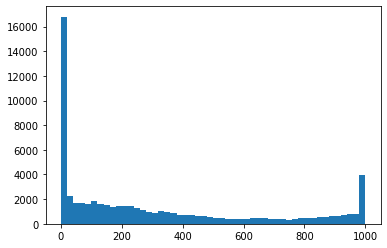

In [92]:
# observe y(busy time)'s distribution
plt.hist(df_train['busyTimeMsPerSecond'], bins=50)
plt.show()

In [109]:
# split x, y
X = df_train.filter(items=['VID',
                          'in_stream_num',
                          'out_stream_num',
                          'parallelism',
                          'numBytesInPerSecond',
                          'numRecordsInPerSecond',]).copy()
y = df_train['busyTimeMsPerSecond'].copy()

In [110]:
# check how many vertice
uniq_vids = X['VID'].unique()
print(len(uniq_vids), ' unique vids, they are: ', list(uniq_vids))
# tokenize and fit
tokenizer = Tokenizer(num_words=22)
tokenizer.fit_on_texts(X['VID'])
X['tokenized_VID'] = X['VID'].apply(lambda row: tokenizer.texts_to_sequences([row])[0][0])
X

21  unique vids, they are:  ['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v2', 'q5v3', 'q7v1', 'q7v2', 'q9v1', 'q9v2', 'q3v1', 'q8v1', 'q8v2', 'q8v3', 'q11v1', 'q12v1', 'q16v1', 'q17v1', 'q18v1', 'q19v1', 'q20v1']


,VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond,tokenized_VID
2,q4v1,1,1,2,3.523568e+04,846.800000,1
3,q4v1,1,1,2,3.443827e+04,828.216667,1
4,q4v2,1,1,2,2.258533e+04,549.983333,2
5,q4v2,1,1,2,2.185323e+04,532.116667,2
6,q4v3,1,0,2,9.076467e+03,273.950000,3
...,...,...,...,...,...,...,...
108235,q20v1,1,0,16,3.477390e+06,15533.216667,20
108236,q20v1,1,0,16,3.424530e+06,15289.300000,20
108237,q20v1,1,0,16,3.447554e+06,15400.683333,20
108238,q20v1,1,0,16,3.440923e+06,15364.700000,20


In [111]:
X = X.filter(items=['tokenized_VID',
                      'in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
X

,tokenized_VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond
2,1,1,1,2,3.523568e+04,846.800000
3,1,1,1,2,3.443827e+04,828.216667
4,2,1,1,2,2.258533e+04,549.983333
5,2,1,1,2,2.185323e+04,532.116667
6,3,1,0,2,9.076467e+03,273.950000
...,...,...,...,...,...,...
108235,20,1,0,16,3.477390e+06,15533.216667
108236,20,1,0,16,3.424530e+06,15289.300000
108237,20,1,0,16,3.447554e+06,15400.683333
108238,20,1,0,16,3.440923e+06,15364.700000


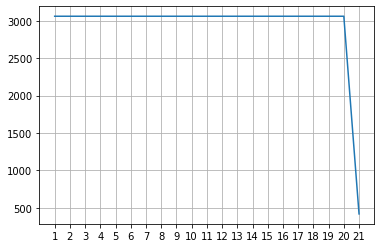

In [112]:
# check whether bias on amount
data_amount_for_vertices = []
max_vid = X['tokenized_VID'].max()
for i in range(1, max_vid+1):
    data_amount_for_vertices.append(len(X[X['tokenized_VID']==i]))

plt.plot(range(1, max_vid+1), data_amount_for_vertices)
plt.xticks(list(range(1, max_vid+1)))
plt.grid()

plt.show()

In [130]:
print(
    [(i,tokenizer.sequences_to_texts([[i]])[0]) for i in range(1,22)]
)
print([tokenizer.sequences_to_texts([[i]])[0] for i in range(1,22)])
# we should ignore the following jobs: q10, q15

[(1, 'q4v1'), (2, 'q4v2'), (3, 'q4v3'), (4, 'q5v1'), (5, 'q5v2'), (6, 'q5v3'), (7, 'q7v2'), (8, 'q9v1'), (9, 'q9v2'), (10, 'q3v1'), (11, 'q8v1'), (12, 'q8v2'), (13, 'q8v3'), (14, 'q11v1'), (15, 'q12v1'), (16, 'q16v1'), (17, 'q17v1'), (18, 'q18v1'), (19, 'q19v1'), (20, 'q20v1'), (21, 'q7v1')]
['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v2', 'q5v3', 'q7v2', 'q9v1', 'q9v2', 'q3v1', 'q8v1', 'q8v2', 'q8v3', 'q11v1', 'q12v1', 'q16v1', 'q17v1', 'q18v1', 'q19v1', 'q20v1', 'q7v1']


In [115]:
# drop invalid vertices and resample the left
# true_indice = (X['tokenized_VID'] != 16) & (X['tokenized_VID'] != 23)
# X = X[true_indice]
# y = y[true_indice]

In [116]:
# normalize
for col in X.columns:
    if col != 'tokenized_VID':
        X[col] = X[col] / X[col].abs().max()
y = y / y.abs().max()

In [117]:
# split training/testing set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=188)
Xtrain

,tokenized_VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond
36461,3,0.5,0.0,1.000,0.000033,0.000000
17133,8,0.5,0.5,0.500,0.115789,0.056049
5715,2,0.5,0.5,0.250,0.058374,0.165697
55607,14,0.5,0.0,0.750,0.019533,0.068782
1393,1,0.5,0.5,0.125,0.093856,0.263253
...,...,...,...,...,...,...
5478,7,1.0,0.0,0.250,0.093507,0.085118
22562,7,1.0,0.0,0.750,0.055331,0.050345
32503,4,0.5,1.0,1.000,0.003978,0.014003
11433,6,1.0,0.0,0.375,0.003209,0.007591


In [118]:
# further split
Xtrain_a = Xtrain.filter(items=['tokenized_VID'])
Xtrain_b = Xtrain.filter(items=['in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
Xtest_a = Xtest.filter(items=['tokenized_VID'])
Xtest_b = Xtest.filter(items=['in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
Xtrain_a

,tokenized_VID
36461,3
17133,8
5715,2
55607,14
1393,1
...,...
5478,7
22562,7
32503,4
11433,6


In [119]:
Xtest_b

,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond
8671,0.5,0.0,0.3750,0.127553,0.022311
19287,0.5,0.5,0.0625,0.052783,0.186092
105903,0.5,0.0,1.0000,0.355060,0.188176
6656,0.5,0.0,0.2500,0.455497,0.079331
29787,0.5,0.5,1.0000,0.001726,0.004858
...,...,...,...,...,...
25760,0.5,0.0,0.7500,0.087169,0.015209
25162,0.5,1.0,0.7500,0.032447,0.114380
15966,0.5,0.0,0.5000,0.273836,0.047760
32627,0.5,1.0,1.0000,0.012786,0.045001


In [120]:
def build_naive_model(input_A_size=1, input_B_size=5, voc_num=17, embedding_size=8, dense_size1=16):
    # define 2 submodel, then combine with concats
    
    # an input
    inputA = Input((input_A_size,))
    inputB = Input((input_B_size,))
    embeddingA = Embedding(voc_num, embedding_size, input_length=input_A_size)(inputA)
    flatten_embeddingA = Flatten()(embeddingA)
    # another input
    input_layer = Concatenate()([flatten_embeddingA, inputB])
    middle_layer = Dense(dense_size1, activation='relu')(input_layer)
    # define output
    output = Dense(1,)(middle_layer)

    # modelize
    model = Model(inputs=[inputA, inputB], outputs=output)
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    model.summary()
    return model

In [121]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [122]:
model = build_naive_model(voc_num=22, embedding_size=6, dense_size1=8)

EPOCHS = 1000

history = model.fit(
  [Xtrain_a, Xtrain_b], ytrain,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 6)         132         input_7[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 6)            0           embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 5)]          0                                            
____________________________________________________________________________________________

In [123]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()

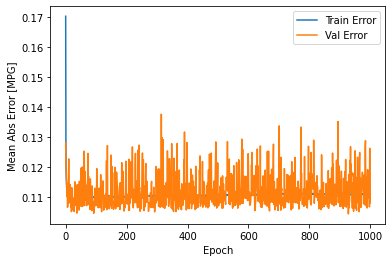

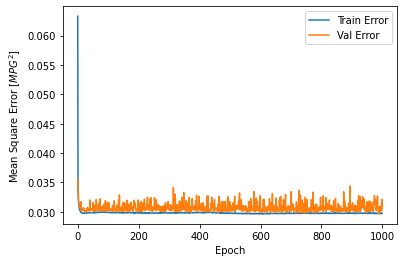

In [124]:
plot_history(history)

15405 15405


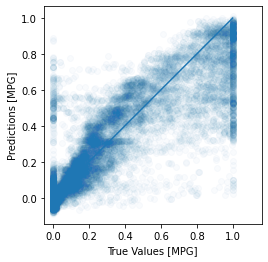

In [125]:
test_predictions = model.predict([Xtest_a, Xtest_b]).flatten()

plt.scatter(ytest, test_predictions, alpha=0.025)
print(len(ytest), len(test_predictions))
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0,1000])
# plt.ylim([0,1000])
_ = plt.plot([0, 1], [0, 1])
plt.show()

In [126]:
np.mean(abs(np.array(ytest) - np.array(test_predictions))), np.median(abs(np.array(ytest) - np.array(test_predictions)))

(0.10772130255660467, 0.05873970031738282)

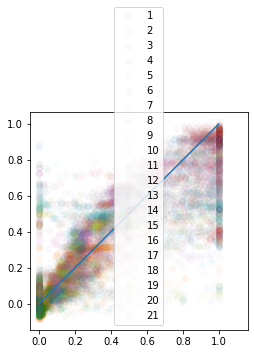

In [127]:
for i in range(1, 22):
    indice = Xtest_a['tokenized_VID'] == i
    test_predictions = model.predict([Xtest_a[indice], Xtest_b[indice]]).flatten()
    
    showscale = max(max(test_predictions), max(ytest[indice]))
    plt.scatter(ytest[indice], test_predictions, label=str(i), alpha=0.025)

plt.plot([0,1],[0,1])
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.show()

vid 1 0.15736245613237415 0.11244434118270874
vid 2 0.06484680081973286 0.050706565380096436
vid 3 0.03391198997625803 0.02544473457336426
vid 4 0.1594274911712235 0.11728650331497192
vid 5 0.041165491012947815 0.026916444301605225
vid 6 0.049123017663955694 0.022205114364624023
vid 7 0.17715334295565102 0.11473852777481075
vid 8 0.23208568977661084 0.16864775395393372
vid 9 0.06942617590964725 0.036759732723236085
vid 10 0.023519760355861792 0.019544036388397214
vid 11 0.057655018878326816 0.03291699028015137
vid 12 0.06150300006145507 0.044097618341445925
vid 13 0.07142057886968056 0.048235822200775144
vid 14 0.13352788856020256 0.09026450920104978
vid 15 0.11785033133039387 0.09298213052749633
vid 16 0.08801566697587622 0.0636286664009094
vid 17 0.10208939553733835 0.07448469519615175
vid 18 0.1155103269420172 0.08527005743980408
vid 19 0.17567786109507233 0.11948932301998139
vid 20 0.21592494912777538 0.1603830463886261
vid 21 0.19480816601477946 0.14266796112060548


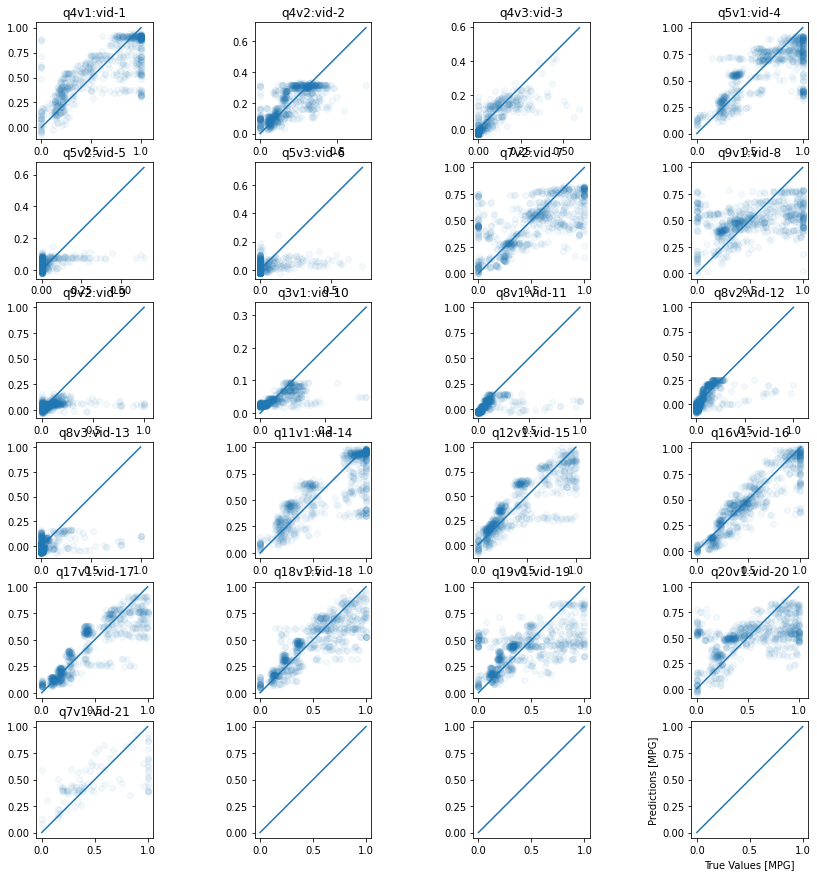

In [131]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
tokenize_dict = {}
for k in ['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v2', 'q5v3', 'q7v2', 'q9v1', 'q9v2', 'q3v1', 'q8v1', 'q8v2', 'q8v3', 'q11v1', 'q12v1', 'q16v1', 'q17v1', 'q18v1', 'q19v1', 'q20v1', 'q7v1']:
    tokenize_dict[tokenizer.texts_to_sequences([k])[0][0]] = k
    

for i in range(1,25):
    ax = axs[(i-1)//4, (i-1)%4]
    if i >= 22:
        ax.plot([0,1],[0,1])
        ax.axis('equal')
        ax.axis('square')
        continue
        
    indice = Xtest_a['tokenized_VID'] == i
    test_predictions = model.predict([Xtest_a[indice], Xtest_b[indice]]).flatten()
    
    showscale = max(max(test_predictions), max(ytest[indice]))
    ax.scatter(ytest[indice], test_predictions, label='q'+str(i), alpha=0.05)
    
    # tell accu for each vertex
    print(
        'vid', i,
        np.mean(abs(np.array(ytest[indice]) - np.array(test_predictions))),
        np.median(abs(np.array(ytest[indice]) - np.array(test_predictions))),
    )
    
    ax.plot([0,showscale],[0,showscale])
    ax.set_title(tokenize_dict[i]+':'+'vid-'+str(i))
    ax.axis('equal')
    ax.axis('square')
#     plt.scatter(ytest[indice], test_predictions,)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
# fig.axis('equal')
# fig.axis('square')
# fig.xlim([0,1])
# fig.ylim([0,1])
# _ = plt.plot([0, 1], [0, 1])
plt.show()

## t-SNE analysis on embeddings

In [132]:
# fetech embeddings
embeddings = model.trainable_variables[0]
embeddings = np.array(embeddings)
# print('embeddings:', embeddings)
# make colors
color_dict = {}
cctr = 1
for k in ['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v2', 'q5v3', 'q7v2', 'q9v1', 'q9v2', 'q3v1', 'q8v1', 'q8v2', 'q8v3', 'q11v1', 'q12v1', 'q16v1', 'q17v1', 'q18v1', 'q19v1', 'q20v1', 'q7v1']:
    color_dict[k] = cctr * 17
    cctr += 1
color_dict
# t-SNE analysis
tSNE_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(embeddings)
tSNE_embedded

array([[-333.20987 , -123.8358  ],
       [ -33.959175, -268.60278 ],
       [ 440.04758 ,  397.04852 ],
       [ 150.76498 ,  362.27374 ],
       [-232.09718 , -259.3989  ],
       [ 450.08047 ,  342.82074 ],
       [ -30.405891,  397.50986 ],
       [-236.72183 , -214.83195 ],
       [  10.467164, -268.52887 ],
       [ 193.5929  ,  339.7409  ],
       [  72.21169 ,  422.6386  ],
       [-175.98363 , -248.31569 ],
       [  94.13101 , -236.92046 ],
       [-316.07492 , -185.71883 ],
       [-111.11311 , -264.77823 ],
       [  92.43347 , -283.50467 ],
       [-426.3902  , -250.04248 ],
       [ 270.1833  ,  436.07727 ],
       [  11.888758,  415.91364 ],
       [ 174.23282 ,  407.3149  ],
       [-394.6478  , -220.90593 ],
       [ 396.43808 ,  390.28992 ]], dtype=float32)

In [133]:
# embed_layer = model.get_layer('embedding')

In [134]:
# for i in range(11):
#     print(embed_layer(np.array([[i]])))

In [135]:
embeddings

array([[ 3.57395299e-02,  8.06235150e-03, -3.74955907e-02,
        -3.39482054e-02,  1.23462565e-02, -1.59011856e-02],
       [ 1.13631797e+00, -8.71300697e+00, -1.53374147e+01,
        -2.91174412e+01, -1.15212708e+01, -1.00926161e+01],
       [ 4.74400806e+00,  1.45451097e+01, -3.14076691e+01,
        -1.09569511e+01,  1.78568554e+01, -9.63525963e+00],
       [ 2.18789787e+01, -5.58547354e+00,  9.31024742e+00,
         2.55261765e+01,  2.58095055e+01, -1.60838947e+01],
       [-4.02473211e+00, -2.86237001e+00, -2.35737762e+01,
        -1.08697271e+01, -2.11060047e+01, -1.05461378e+01],
       [ 1.07403269e+01,  2.78513813e+01, -4.96649208e+01,
        -1.36362076e+01,  2.01553040e+01, -4.45996141e+00],
       [-2.72763801e+00, -7.94400358e+00,  3.45084229e+01,
         2.99869728e+01,  3.94443178e+00, -9.77673531e+00],
       [-5.55253744e+00, -3.76001549e+00, -2.15469303e+01,
        -1.03292923e+01, -1.79221001e+01, -1.14029608e+01],
       [-1.49511995e+01, -5.74085093e+00, -1.351

In [45]:
print(
    [[i] for i in range(1,17)], '\n', tokenizer.sequences_to_texts([[i] for i in range(1,17)])
)

[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16]] 
 ['q4v2', 'q9v1', 'q5v1', 'q11v1', 'q7v2', 'q4v1', 'q8v2', 'q9v2', 'q8v1', 'q3v1', 'q4v3', 'q8v3', 'q5v3', 'q5v2', 'q7v1', 'q10v1']


In [41]:
def calc_pair_distances(vectors):
    l = len(embeddings)
    res = []
    for i in range(l):
        v1 = embeddings[i]
        tmp = []
        for j in range(l):
            v2 = embeddings[j]
            dis = np.linalg.norm(v1 - v2)
            tmp.append(dis)
        res.append(tmp)
    res = np.array(res)
    return res

In [50]:
# test ground
embedding_dict = {}

In [51]:
tok_texts = tokenizer.sequences_to_texts([[i] for i in range(0,17)])
for i in range(0, 17):
    t_seq = i
    t_txt = tok_texts[i]
    embedding_dict[t_txt] = embedding_dict.get(t_txt, [])
    embedding_dict[t_txt].append(tSNE_embedded[i])

In [ ]:
pair_diss = calc_pair_distances(embeddings)
# pair_diss[0]
pair_diss

## Part 1.2 on vertex level

In [15]:
# define wanted dict
wanted_dict2 = {}
wanted_dict2['run_confs'] = ['qid']
wanted_dict2['vertex_level_metrics'] = ['parallelism', 'numBytesInPerSecond', 'numRecordsInPerSecond', 'busyTimeMsPerSecond']
wanted_dict2['vertex_id'] = 'idx'
wanted_dict2['sub_level_metrics'] = ['Shuffle.Netty.Input.Buffers.inPoolUsage']

In [16]:
# do data cleaning for vertex-level
scleaner2 = sequential_cleaner(wanted_dict2)
df_raw[:].apply(scleaner2.clean_row, axis=1)
len(scleaner2.dataset), scleaner2.dataset[:1]

(65400, [[4, 0, 2, 0.0, 0.0, 'NaN', 0, '0.0']])

In [17]:
scleaner2.get_head()

['qid',
 'vertex_idx',
 'parallelism',
 'numBytesInPerSecond',
 'numRecordsInPerSecond',
 'busyTimeMsPerSecond',
 'sub_idx',
 'Shuffle.Netty.Input.Buffers.inPoolUsage']

In [18]:
# make df and replace nan
df2 = pd.DataFrame(scleaner2.dataset, columns=scleaner2.get_head())
df2 = df2.replace('NaN', np.nan)
(df2.shape[0], df2.shape[1], df2.keys())

(65400,
 8,
 Index(['qid', 'vertex_idx', 'parallelism', 'numBytesInPerSecond',
        'numRecordsInPerSecond', 'busyTimeMsPerSecond', 'sub_idx',
        'Shuffle.Netty.Input.Buffers.inPoolUsage'],
       dtype='object'))

In [29]:
# col name & dtype transform

df_naive2 = df2
df_naive2 = df_naive2[df_naive2['busyTimeMsPerSecond'].notnull()]
df_naive2.rename(columns = {'qid':'query_idx',}, inplace = True)

df_naive2 = df_naive2.astype({"query_idx": int, 'vertex_idx': int, 'parallelism':int,
                              'numBytesInPerSecond': float, 'numRecordsInPerSecond': float, 'busyTimeMsPerSecond': float,})

# complete information
df_naive2['in_stream_num'] = df_naive2.apply(complete_row_in, axis=1)
df_naive2['out_stream_num'] = df_naive2.apply(complete_row_out, axis=1)

df_train2 = df_naive2.filter(items=['query_idx',
                            'vertex_idx',
                            'in_stream_num',
                            'out_stream_num',
                            'parallelism',
                            'numBytesInPerSecond',
                            'numRecordsInPerSecond',
                            'busyTimeMsPerSecond',])

df_train2 = df_train2[df_train2['busyTimeMsPerSecond'] > 10] # filter out abnormal starting noise
df_train2 = df_train2[df_train2['busyTimeMsPerSecond'] < 1000] # filter out abnormal starting noise

df_train2['VID'] = 'q' + df_train2['query_idx'].astype(str) + 'v' + df_train2['vertex_idx'].astype(str)

df_train2 = df_train2.filter(items=['VID',
                                  'in_stream_num',
                                  'out_stream_num',
                                  'parallelism',
                                  'numBytesInPerSecond',
                                  'numRecordsInPerSecond',
                                  'busyTimeMsPerSecond'])
df_train2 = df_train2.drop_duplicates()

print(df_train2.shape)

/home/flink/workspace/yimin/data_explore/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4945, 7)


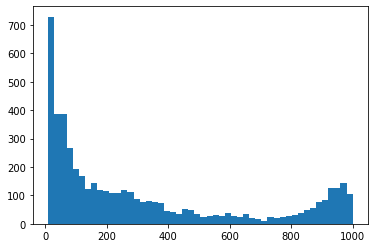

In [30]:
# observe y(busy time)'s distribution
plt.hist(df_train2['busyTimeMsPerSecond'], bins=50)
plt.show()

In [31]:
# split x, y
X = df_train2.filter(items=['VID',
                          'in_stream_num',
                          'out_stream_num',
                          'parallelism',
                          'numBytesInPerSecond',
                          'numRecordsInPerSecond',]).copy()
y = df_train2['busyTimeMsPerSecond'].copy()

In [32]:
# check how many vertice
uniq_vids = X['VID'].unique()
print(len(uniq_vids), ' unique vids, they are: ', list(uniq_vids))
# tokenize and fit
tokenizer = Tokenizer(num_words=17)
tokenizer.fit_on_texts(X['VID'])
X['tokenized_VID'] = X['VID'].apply(lambda row: tokenizer.texts_to_sequences([row])[0][0])
X

16  unique vids, they are:  ['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v3', 'q7v1', 'q7v2', 'q9v1', 'q9v2', 'q5v2', 'q3v1', 'q11v1', 'q8v2', 'q8v1', 'q10v1', 'q8v3']


,VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond,tokenized_VID
2,q4v1,1,1,2,3.483698e+04,837.508333,3
4,q4v2,1,1,2,2.221928e+04,541.050000,5
6,q4v3,1,0,2,5.615592e+03,169.075000,7
10,q4v1,1,1,2,6.854882e+04,1648.941667,3
12,q4v2,1,1,2,4.321310e+04,1052.316667,5
...,...,...,...,...,...,...,...
65256,q11v1,1,0,16,1.519069e+06,45998.042708,1
65288,q11v1,1,0,16,1.595478e+06,48319.280208,1
65320,q11v1,1,0,16,1.621987e+06,49122.965625,1
65352,q11v1,1,0,16,1.614056e+06,48882.880208,1


In [33]:
X = X.filter(items=['tokenized_VID',
                      'in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
X

,tokenized_VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond
2,3,1,1,2,3.483698e+04,837.508333
4,5,1,1,2,2.221928e+04,541.050000
6,7,1,0,2,5.615592e+03,169.075000
10,3,1,1,2,6.854882e+04,1648.941667
12,5,1,1,2,4.321310e+04,1052.316667
...,...,...,...,...,...,...
65256,1,1,0,16,1.519069e+06,45998.042708
65288,1,1,0,16,1.595478e+06,48319.280208
65320,1,1,0,16,1.621987e+06,49122.965625
65352,1,1,0,16,1.614056e+06,48882.880208


In [34]:
# normalize
for col in X.columns:
    if col != 'tokenized_VID':
        X[col] = X[col] / X[col].abs().max()
y = y / y.abs().max()

In [35]:
# split training/testing set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=666)
Xtrain

,tokenized_VID,in_stream_num,out_stream_num,parallelism,numBytesInPerSecond,numRecordsInPerSecond
656,14,0.5,0.5,0.1250,0.009936,0.020520
43896,11,0.5,0.5,0.2500,0.001590,0.004049
3960,2,0.5,0.5,0.1875,0.350704,0.123738
1791,4,0.5,1.0,0.1875,0.007597,0.019481
30038,5,0.5,0.5,1.0000,0.013523,0.027708
...,...,...,...,...,...,...
11000,9,0.5,0.0,0.3750,0.309609,0.039324
242,2,0.5,0.5,0.1250,0.070996,0.025046
23538,4,0.5,1.0,0.7500,0.030512,0.078287
10642,8,1.0,0.0,0.3750,0.002371,0.004066


In [36]:
# further split
Xtrain_a = Xtrain.filter(items=['tokenized_VID'])
Xtrain_b = Xtrain.filter(items=['in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
Xtest_a = Xtest.filter(items=['tokenized_VID'])
Xtest_b = Xtest.filter(items=['in_stream_num',
                      'out_stream_num',
                      'parallelism',
                      'numBytesInPerSecond',
                      'numRecordsInPerSecond',])
Xtrain_a

,tokenized_VID
656,14
43896,11
3960,2
1791,4
30038,5
...,...
11000,9
242,2
23538,4
10642,8


In [39]:
model = build_naive_model(embedding_size=8, dense_size1=8)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  [Xtrain_a, Xtrain_b], ytrain,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 8)         136         input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 8)            0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
______________________________________________________________________________________________

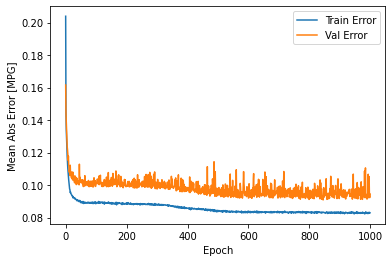

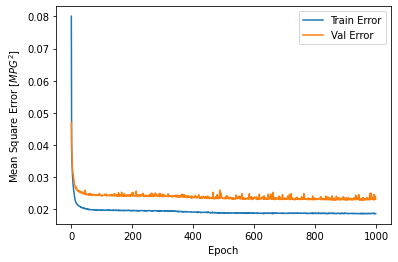

In [41]:
plot_history(history)

1237 1237


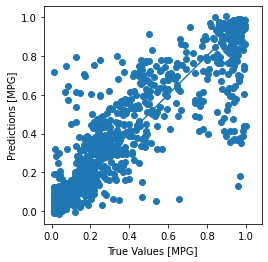

In [42]:
test_predictions = model.predict([Xtest_a, Xtest_b]).flatten()

plt.scatter(ytest, test_predictions)
print(len(ytest), len(test_predictions))
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0,1000])
# plt.ylim([0,1000])
_ = plt.plot([0, 1], [0, 1])
plt.show()

In [43]:
np.mean(abs(np.array(ytest) - np.array(test_predictions))), np.median(abs(np.array(ytest) - np.array(test_predictions)))

(0.08675951601064319, 0.04309306035976487)

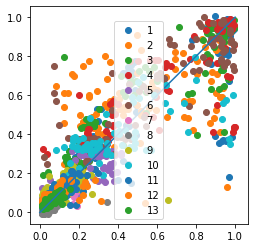

In [44]:
for i in range(1, 14):
    indice = Xtest_a['tokenized_VID'] == i
    test_predictions = model.predict([Xtest_a[indice], Xtest_b[indice]]).flatten()
    
    showscale = max(max(test_predictions), max(ytest[indice]))
    plt.scatter(ytest[indice], test_predictions, label=str(i))

plt.plot([0,1],[0,1])
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.show()

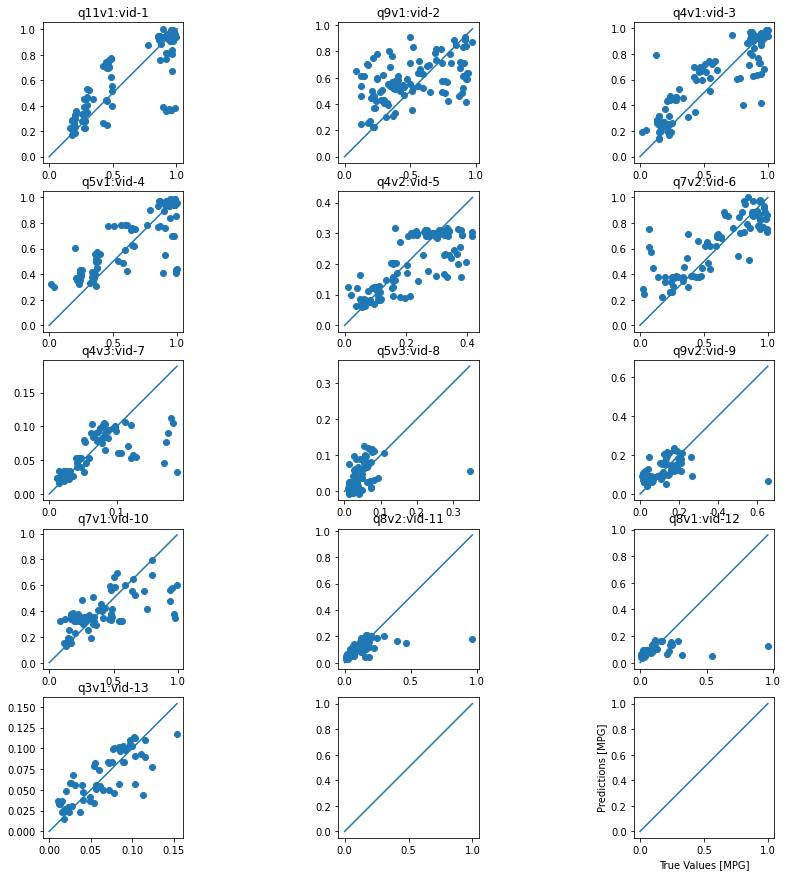

In [45]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
tokenize_dict = {}
for k in ['q4v1', 'q4v2', 'q4v3', 'q5v1', 'q5v2', 'q5v3', 'q7v1', 'q7v2', 'q9v1', 'q9v2', 'q3v1', 'q8v2', 'q11v1', 'q8v1', 'q8v3', 'q10v1']:    
    tokenize_dict[tokenizer.texts_to_sequences([k])[0][0]] = k
    

for i in range(1,16):
    ax = axs[(i-1)//3, (i-1)%3]
    if i >= 14:
        ax.plot([0,1],[0,1])
        ax.axis('equal')
        ax.axis('square')
        continue
        
    indice = Xtest_a['tokenized_VID'] == i
    test_predictions = model.predict([Xtest_a[indice], Xtest_b[indice]]).flatten()
    
    showscale = max(max(test_predictions), max(ytest[indice]))
    ax.scatter(ytest[indice], test_predictions, label='q'+str(i))
    ax.plot([0,showscale],[0,showscale])
    ax.set_title(tokenize_dict[i]+':'+'vid-'+str(i))
    ax.axis('equal')
    ax.axis('square')
#     plt.scatter(ytest[indice], test_predictions,)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
# fig.axis('equal')
# fig.axis('square')
# fig.xlim([0,1])
# fig.ylim([0,1])
# _ = plt.plot([0, 1], [0, 1])
plt.show()